In [87]:
import pandas as pd
import numpy as np
from time import strptime

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter


In [140]:
x_vals = list(range(-5,6))
y_vals = [21, 18, 16, 5, 12, 9, 24, 28, 28, 25, 6]#[np.random.randint(5,30) for i in x_vals]
y_vals

[21, 18, 16, 5, 12, 9, 24, 28, 28, 25, 6]

In [244]:
def get_poly_value(poly_coef_values ,x_values):

    poly_values = []
    for x_val in x_values:
        high_deg_x_values = [ x_val**power  for power in range(len(poly_coef_values)-1, -1,-1)]
        poly_val = np.matmul(poly_coef_values,np.array(high_deg_x_values))
        poly_values.append(poly_val)
    
    return poly_values
    
poly_coefs = np.polyfit(x=x_vals,y=y_vals,deg=5)
poly_vals = get_poly_value(poly_coef_values =poly_coefs, x_values =x_vals )



def zeros_to_add(values,window):
    zeros_array = [0 for i in range(window//2)]
    return zeros_array+values+zeros_array


window=9
test_array = zeros_to_add(values=y_vals, window=window)
is_even_num = True if window%2==0 else False
center_point = window//2


replica_sg_vals = []
for index,i in enumerate(test_array):
    current_window_y = test_array[index:index+window]
    current_window_x = list(range(len(current_window_y)))#list(range(len(test_array)))[index:index+window]

    if len(current_window_y)==window:

        temp_poly_coefs = np.polyfit(x=current_window_x ,#list(range(len(current_window_y))) 
                                     y=current_window_y,
                                     deg=5)
        temp_poly_vals = get_poly_value(poly_coef_values =temp_poly_coefs, x_values =current_window_x )

        replica_sg_vals.append(temp_poly_vals[center_point])



In [257]:
print('x values: ',x_vals)
print('y values: ',y_vals)

x values:  [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
y values:  [21, 18, 16, 5, 12, 9, 24, 28, 28, 25, 6]


<Axes: >

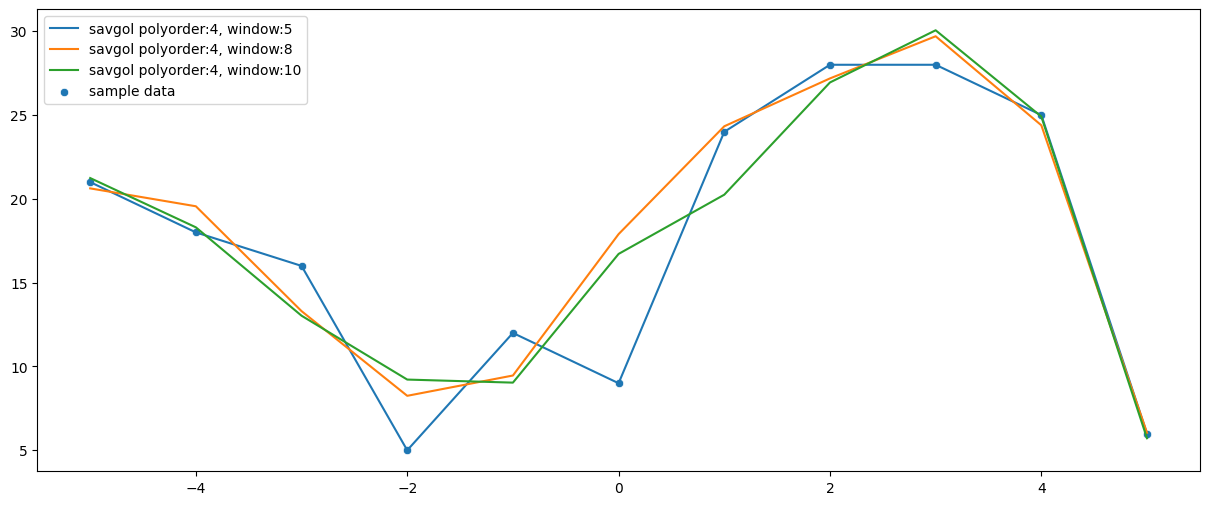

In [255]:
plt.figure(figsize=(15,6))
for window,poly_order in [(5,4),(8,4),(10,4)]: #,(6,5),(6,4)
    sns.lineplot(x=x_vals,y=savgol_filter(x=y_vals,window_length=window
                                      ,polyorder=poly_order), label=f'savgol polyorder:{poly_order}, window:{window}')
sns.scatterplot(x=x_vals,y=y_vals, label='sample data')

<Axes: >

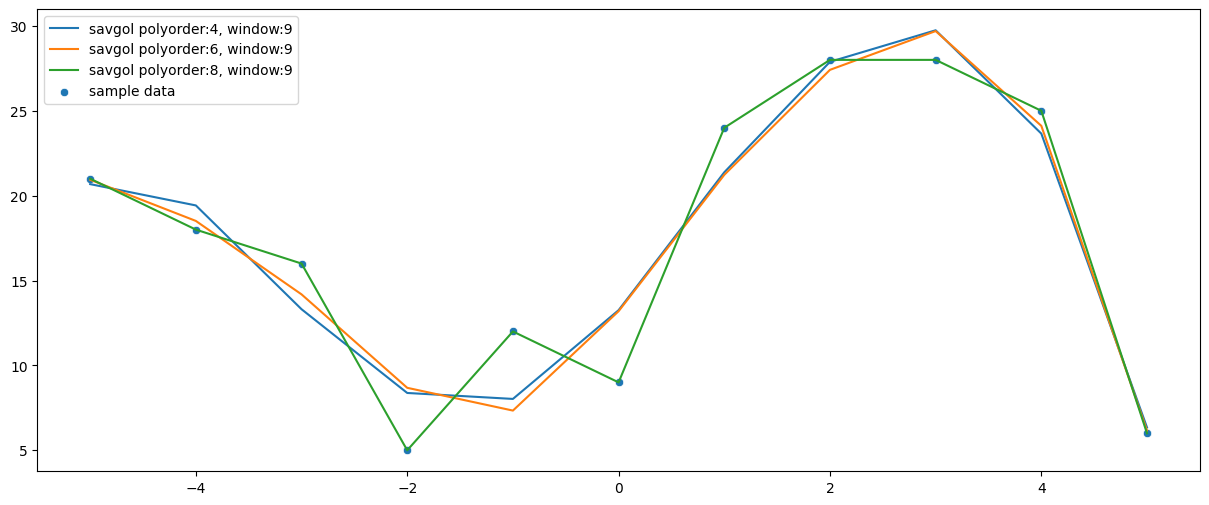

In [259]:
plt.figure(figsize=(15,6))
for window,poly_order in [(9,4),(9,6),(9,8)]: #,(6,5),(6,4)
    sns.lineplot(x=x_vals,y=savgol_filter(x=y_vals,window_length=window
                                      ,polyorder=poly_order), label=f'savgol polyorder:{poly_order}, window:{window}')
sns.scatterplot(x=x_vals,y=y_vals, label='sample data')

In [97]:
main_bookings_df = pd.read_csv('../../time_series_work/hotel_bookings.csv')

# to get a rough estimate of room bookings, im going to assume there are only triple rooms and adults+children (not babies) are considered for total people
approx_bookings = lambda total_people: total_people//3+ (0 if total_people%3==0 else 1)

analysis_cpy_df = main_bookings_df.copy()
analysis_cpy_df['arrival_date'] = pd.to_datetime(analysis_cpy_df.apply(lambda x:f"{x.arrival_date_year}-{strptime(x.arrival_date_month,'%B').tm_mon:02}-{x.arrival_date_day_of_month}", axis=1))
analysis_cpy_df['bookings'] = analysis_cpy_df.apply(lambda x: approx_bookings(x.adults+x.children), axis=1)
analysis_cpy_df['booking_date'] = analysis_cpy_df['arrival_date']- pd.to_timedelta(analysis_cpy_df['lead_time'], unit='days')
analysis_cpy_df['reservation_status_date_check'] = pd.to_datetime(analysis_cpy_df['arrival_date'])+pd.to_timedelta(analysis_cpy_df['stays_in_weekend_nights']+analysis_cpy_df['stays_in_week_nights'], unit='days')


needed_columns = ['hotel', 'arrival_date','booking_date', 'adr', 'bookings', 'revenue']

#    CONDITIONS
# filter rows where adults==0
# filter out cancellations, for simplicity
# check missing values after filtering out cancellations
#  -there arent any missing values in the critical columns
# check the date continuity considering max and min arrival dates hotelwise


# dropping rows where adults==0 and bookings are cancelled
final_df = analysis_cpy_df[(analysis_cpy_df.is_canceled==0)&(analysis_cpy_df.adults>0)]

# getting revenue based on approx bookings
final_df['revenue'] = final_df['adr']*final_df['bookings'] 
# summing rows as per the group
final_df = final_df[needed_columns].groupby(['hotel','arrival_date','booking_date']).sum().reset_index()

# recalculating booking lead
final_df['booking_lead'] = (final_df['arrival_date']-final_df['booking_date']).dt.days
final_df = final_df.sort_values(['arrival_date','booking_date','booking_lead'])

print(final_df.columns)
print(final_df.hotel.unique())

for h_type in final_df.hotel.unique():
    print(h_type)
    min_arrival_dt = final_df[final_df.hotel==h_type].arrival_date.min()
    max_arrival_dt = final_df[final_df.hotel==h_type].arrival_date.max()
    print('\tactual num of records:', len(final_df['arrival_date'][final_df.hotel==h_type].drop_duplicates()))
    print('\tneeded num of records:', len(pd.date_range(start=min_arrival_dt, end=max_arrival_dt, freq='1D')))

# considering only resort hotel since it has all the data between min and max arrival dates
final_df = final_df[final_df.hotel=='Resort Hotel'].drop('hotel',axis=1).reset_index(drop=True)


def cumulative_sum_by_arrival_date(group:pd.DataFrame,cumu_sum_cols:list, sorting_cols:list = ['booking_date']) -> pd.DataFrame:
    group = group.sort_values(sorting_cols)

    for col in cumu_sum_cols:
        group[f'cumu_{col}'] = group[col].cumsum()
    return group

#considering the cumulative sums
final_df = final_df.groupby(['arrival_date']).apply(lambda x: cumulative_sum_by_arrival_date(x,cumu_sum_cols=['adr', 'bookings', 'revenue'])).reset_index(drop=True)


C:\Users\sanja\AppData\Local\Temp\ipykernel_19948\1922625721.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['revenue'] = final_df['adr']*final_df['bookings']


Index(['hotel', 'arrival_date', 'booking_date', 'adr', 'bookings', 'revenue',
       'booking_lead'],
      dtype='object')
['Resort Hotel' 'City Hotel']
Resort Hotel
	actual num of records: 793
	needed num of records: 793
City Hotel
	actual num of records: 788
	needed num of records: 793


C:\Users\sanja\AppData\Local\Temp\ipykernel_19948\1922625721.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_df = final_df.groupby(['arrival_date']).apply(lambda x: cumulative_sum_by_arrival_date(x,cumu_sum_cols=['adr', 'bookings', 'revenue'])).reset_index(drop=True)


In [124]:
final_df.arrival_date.unique()

<DatetimeArray>
['2015-07-01 00:00:00', '2015-07-02 00:00:00', '2015-07-03 00:00:00',
 '2015-07-04 00:00:00', '2015-07-05 00:00:00', '2015-07-06 00:00:00',
 '2015-07-07 00:00:00', '2015-07-08 00:00:00', '2015-07-09 00:00:00',
 '2015-07-10 00:00:00',
 ...
 '2017-08-22 00:00:00', '2017-08-23 00:00:00', '2017-08-24 00:00:00',
 '2017-08-25 00:00:00', '2017-08-26 00:00:00', '2017-08-27 00:00:00',
 '2017-08-28 00:00:00', '2017-08-29 00:00:00', '2017-08-30 00:00:00',
 '2017-08-31 00:00:00']
Length: 793, dtype: datetime64[ns]

In [125]:
sub_df = final_df[final_df.arrival_date==pd.to_datetime('2015-07-02')]
sub_df['svgol_rev'] = savgol_filter(x=sub_df['revenue'],window_length=20,polyorder=6)
sub_df =sub_df.groupby(['arrival_date']).apply(lambda x: cumulative_sum_by_arrival_date(x,cumu_sum_cols=['svgol_rev'])).reset_index(drop=True)

sub_df.columns

C:\Users\sanja\AppData\Local\Temp\ipykernel_19948\472767615.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['svgol_rev'] = savgol_filter(x=sub_df['revenue'],window_length=20,polyorder=6)
C:\Users\sanja\AppData\Local\Temp\ipykernel_19948\472767615.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sub_df =sub_df.groupby(['arrival_date']).apply(lambda x: cumulative_sum_by_arrival_date(x,cumu_sum_cols=['svgol_rev'])).reset_index(drop=True)


Index(['arrival_date', 'booking_date', 'adr', 'bookings', 'revenue',
       'booking_lead', 'cumu_adr', 'cumu_bookings', 'cumu_revenue',
       'svgol_rev', 'cumu_svgol_rev'],
      dtype='object')

In [283]:
sub_df2 = final_df.drop(['booking_date','booking_lead','cumu_adr', 'cumu_bookings','cumu_revenue'],axis=1).groupby(['arrival_date']).sum().reset_index().copy()
sub_df2['svgol_rev'] = savgol_filter(x=sub_df2['revenue'],window_length=10,polyorder=4)
sub_df2 = sub_df2[sub_df2.arrival_date>=pd.to_datetime('2017-01-01')]

<Axes: xlabel='arrival_date', ylabel='svgol_rev'>

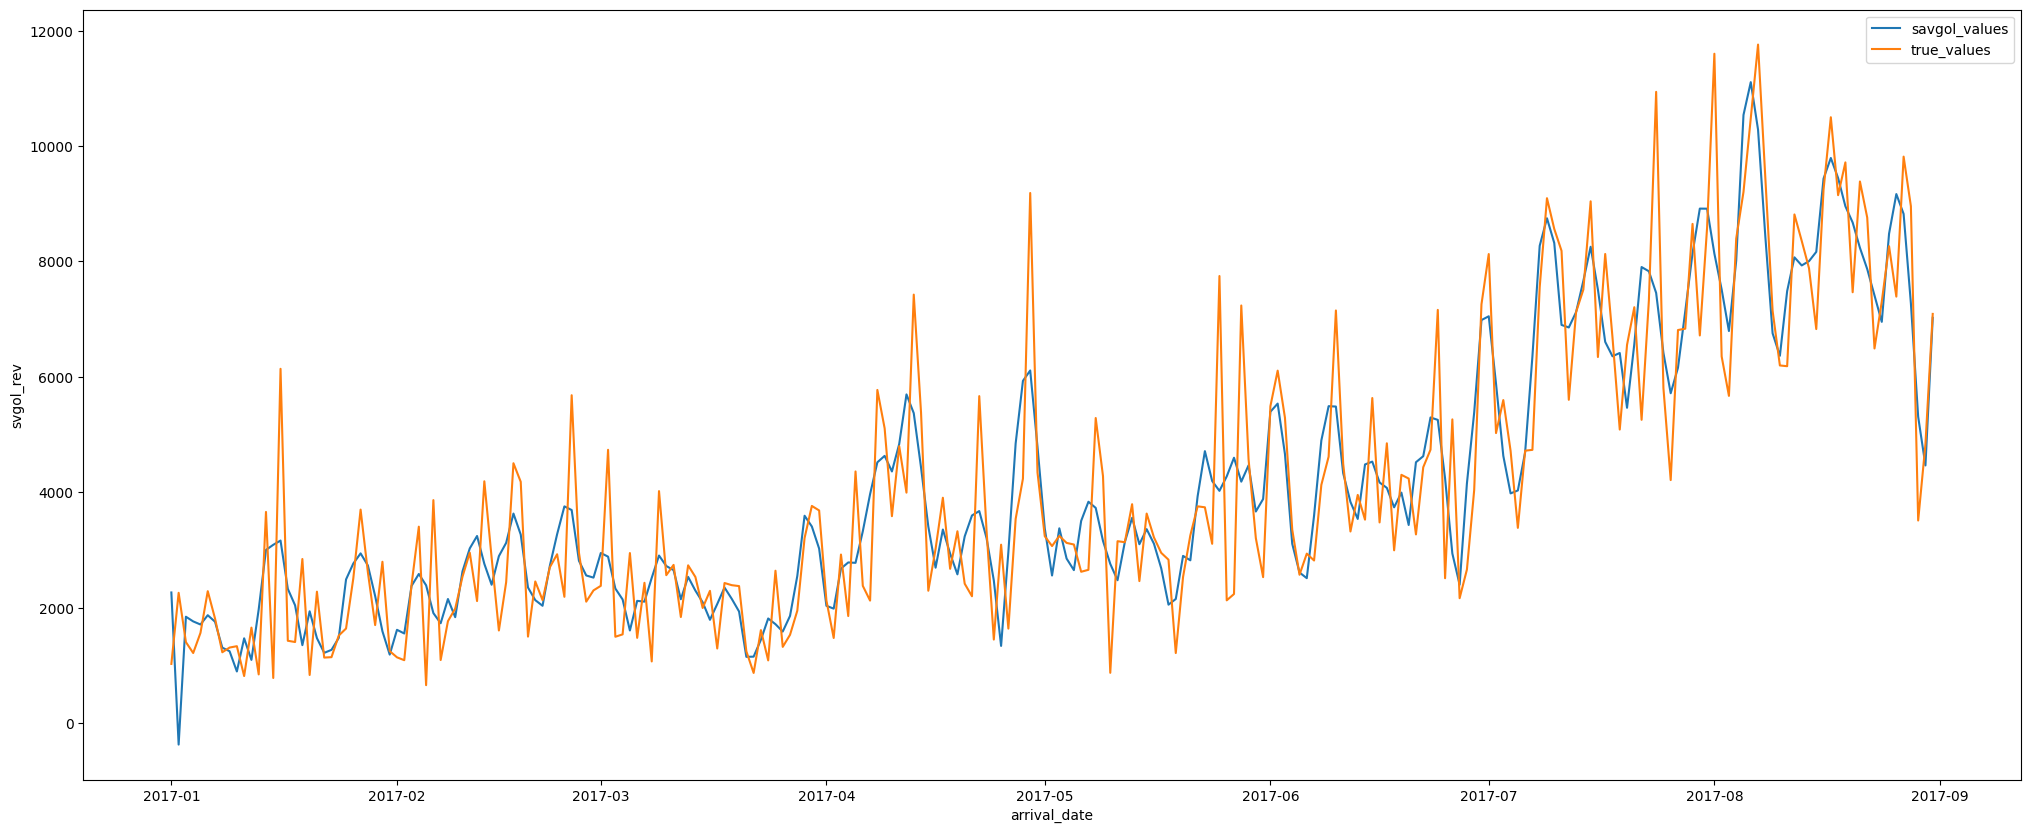

In [284]:
plt.figure(figsize=(25,10))
sns.lineplot(data=sub_df2, x='arrival_date',y='svgol_rev', label='savgol_values')
sns.lineplot(data=sub_df2, x='arrival_date',y='revenue', label='true_values')